C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


age             0
sex             0
SBP             0
BMI             0
HbA1c           0
TotalChol       0
LDL             0
TG              0
HDL             0
NLR             0
CRP          1510
CACS            0
CACS_high       0
dtype: int64
AUC: 0.8977453580901856
              precision    recall  f1-score   support

           0       0.60      0.46      0.52        52
           1       0.91      0.94      0.93       290

    accuracy                           0.87       342
   macro avg       0.75      0.70      0.72       342
weighted avg       0.86      0.87      0.86       342



C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


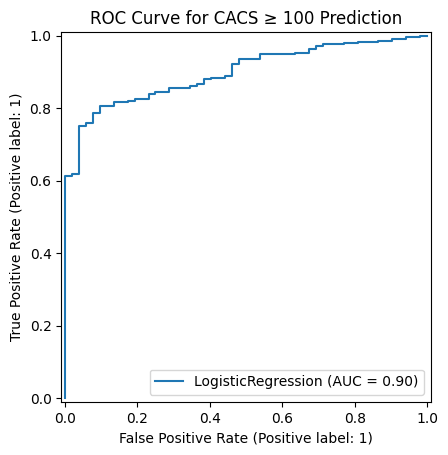

C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [18:35:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


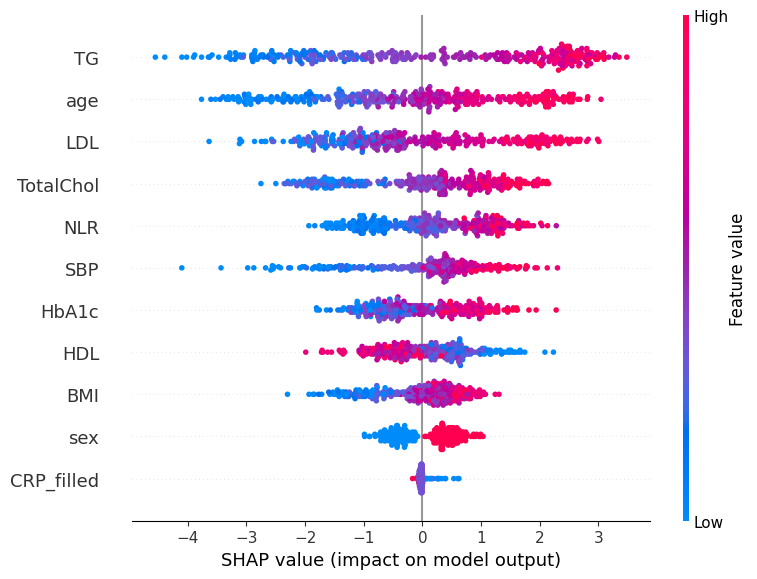

,variable,coefficient,direction,score
0,age,0.073099,+,5
1,sex,0.676060,+,10
2,SBP,0.045327,+,3
3,BMI,0.113153,+,7
4,HbA1c,0.416853,+,10
5,TotalChol,0.018890,+,1
6,LDL,0.028063,+,1
7,TG,0.021399,+,1
8,HDL,-0.037296,-,3
9,NLR,0.403666,+,7


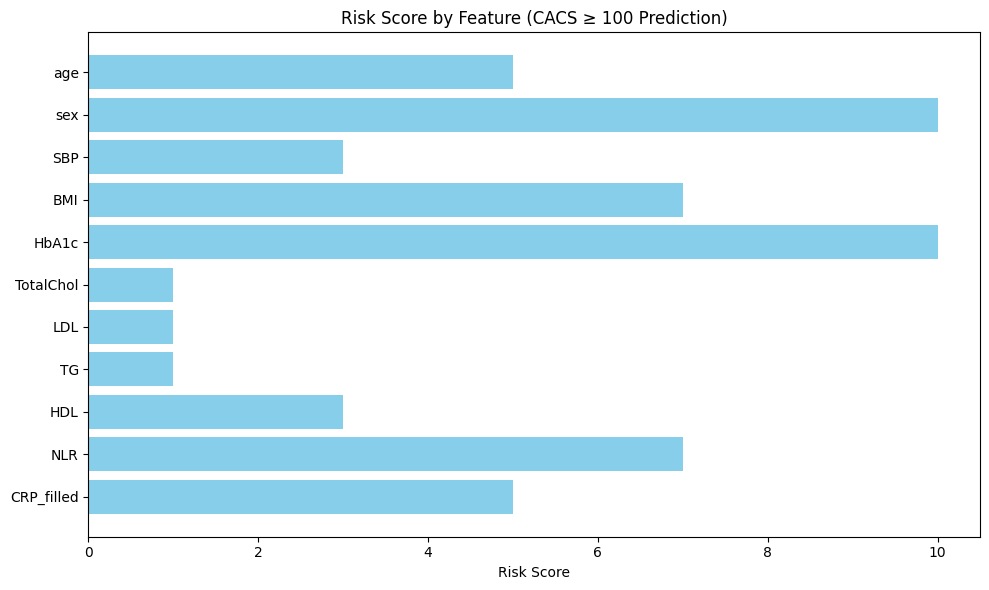

In [1]:
# 📦 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

# 📂 2. 데이터 불러오기
df = pd.read_csv("CDW_CACS_NLR_CRP_1710.csv")  # 다운로드 받은 경로 확인 필요

# 🔍 3. 결측치 확인 및 처리 (CRP는 일부 결측 허용)
print(df.isnull().sum())

# 💡 CRP는 평균 대체 또는 별도 변수로 결측 여부 반영 가능
df["CRP_filled"] = df["CRP"].fillna(df["CRP"].mean())

# 🎯 4. 피처/타겟 설정
X = df[["age", "sex", "SBP", "BMI", "HbA1c", "TotalChol", "LDL", "TG", "HDL", "NLR", "CRP_filled"]]
y = df["CACS_high"]

# ✂️ 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📊 6. 로지스틱 회귀 모델 학습 및 평가
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve for CACS ≥ 100 Prediction")
plt.show()

# 📈 7. SHAP 분석 (XGBoost)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test)       # 전체 변수 영향도
shap.force_plot(shap_values[0])              # 개별 환자 예측 해석

# 🧮 8. 리스크 점수 시스템 생성
coef_df = pd.DataFrame({
    "variable": X.columns,
    "coefficient": model.coef_[0]
})
coef_df["score"] = pd.qcut(coef_df["coefficient"].abs(), q=5, labels=[1, 3, 5, 7, 10]).astype(int)
coef_df["direction"] = coef_df["coefficient"].apply(lambda x: "+" if x > 0 else "-")
score_table = coef_df[["variable", "coefficient", "direction", "score"]]
display(score_table)

# 📊 9. 점수 시각화
plt.figure(figsize=(10, 6))
plt.barh(score_table["variable"], score_table["score"], color="skyblue")
plt.xlabel("Risk Score")
plt.title("Risk Score by Feature (CACS ≥ 100 Prediction)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
